<a href="https://colab.research.google.com/github/Lucho90/Lucho90-Sistema_recomendacion_steam/blob/main/Sistema_de_recomendaci%C3%B3n_basado_en_precios_y_horas_jugadas_STEAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema de recomendación basado en precios y horas jugadas STEAM

Para iniciar traeremos los datos. Llevaremos todo el preprocesamiento al punto similar al proyecto "sistema de recomendación basado en horas" sin ahondar mucho, si te sientes perdido o no entiendes las transformaciones que se realizan, te sugiero ver ese proyecto en este mismo repositorio. 

En esta ocación intentaremos realizar la mejora propuesta en aquel proyecto: Incluir en el sistema de recomendación el factor económico a la hora de evaluar la probabilidad de comprar o no el juego.



In [ ]:
import gzip
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def parse(path):   
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [ ]:
reviws = pd.read_csv('reviws.csv')
reviws['hours'] = pd.to_numeric(reviws['hours'])
reviws = reviws.drop_duplicates()
reviws = reviws.dropna()
gr = reviws.groupby(['username'])
total = pd.DataFrame(gr['hours'].sum())
reviws['total']=total
reviws['total'].fillna(gr.hours.transform("sum"),inplace=True)
reviws['play_game']= reviws['hours']/reviws['total']

maximo= 8760 # Las horas que contiene un año
# Con el outlier minimo ya lidiamos al eliminar quienes tenian 0 horas jugadas.
reviws= reviws.drop(reviws[reviws['total']>maximo].index)
#reviws= reviws.drop(reviws[reviws['total']<minimo].index)



reviws.head()

,username,hours,product_id,total,play_game
0,Chaos Syren,0.1,725280,0.1,1.000000
1,Ariman1,13.2,328100,15.7,0.840764
2,freakfantom,0.1,725280,0.1,1.000000
3,The_Cpt_FROGGY,7.8,631920,184.8,0.042208
4,the_maker988,8.2,35140,8.2,1.000000


In [ ]:
reviws.loc[:,'mean_hour']= np.nan
reviws.loc[:,'mean_hour'].fillna(gr.play_game.transform("mean"),inplace=True)
reviws.loc[:,'std_hour'] = np.nan
reviws.loc[:,'std_hour'].fillna(gr.play_game.transform('std'),inplace=True)

reviws = reviws.fillna(0)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000
1,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037
2,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000
3,The_Cpt_FROGGY,7.8,631920,184.8,0.042208,0.037037,0.013012
4,the_maker988,8.2,35140,8.2,1.000000,1.000000,0.000000


Aquí viene la gran diferencia con respecto al proyecto en donde calificabamos los juegos basados en las horas de uso, esta vez las notas generadas por las horas irán de 0.5 a 2.5, poco tiempo empleado a mucho tiempo empleado jugando respectivamente.

In [ ]:
puntaje_5 =  reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour'] + 2*reviws.loc[:,'std_hour']
puntaje_4 =  reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour'] + 1.5*reviws.loc[:,'std_hour']
puntaje_3 =   reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour'] + reviws.loc[:,'std_hour']
puntaje_2 = reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour'] 
puntaje_1 =   reviws.loc[:,'play_game'] < reviws.loc[:,'mean_hour']        
conditions  = [ puntaje_5,puntaje_4,puntaje_3,puntaje_2,puntaje_1 ]
choices     = [ 2.5,2,1.5,1,0.5 ]

reviws.loc[:,'ranking'] = np.select(conditions, choices, default=np.nan)
reviws.head(10)

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5
1,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5
2,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5
3,The_Cpt_FROGGY,7.8,631920,184.8,0.042208,0.037037,0.013012,1.0
4,the_maker988,8.2,35140,8.2,1.000000,1.000000,0.000000,2.5
5,Szudof,0.2,288690,0.2,1.000000,1.000000,0.000000,2.5
6,Vonder,2.7,35600,21.8,0.123853,0.333333,0.327728,0.5
7,LucaFox,4.0,620900,4.0,1.000000,1.000000,0.000000,2.5
8,rampage1209,34.8,1840,34.8,1.000000,1.000000,0.000000,2.5
9,Devil Azite,0.1,671270,0.1,1.000000,1.000000,0.000000,2.5


Transformado el dataset hasta este punto (mismo del anterior proyecto), lo que se hará es añadir una columna indicando el el precio del producto. Para ello requerimos usar el otro dataset "steam_games".

In [ ]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)
data_games.head(1)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN


Nos quedamos con tres columnas: App_name, price y product_id. La transformación ahora está encaminada a agregar estos datos a nuestro dataset de reviws.

In [ ]:
games = pd.DataFrame(data_games,columns=['app_name','price','id'])
games = games.rename(columns={'app_name':'name','price':'price','id':'product_id'})
games.head()

,name,price,product_id
0,Lost Summoner Kitty,4.99,761140
1,Ironbound,Free To Play,643980
2,Real Pool 3D - Poolians,Free to Play,670290
3,弹炸人2222,0.99,767400
4,Log Challenge,2.99,773570


En orden de cambiar los valores de price a númerico, primero debemos deshacernos de los valores string, esto mediante un diccionario en el que se reemplacen los valores. Ahora si pueden ser valores númericos.

In [ ]:
games["price"].replace({"Free To Play": 0 , "Play the Demo": 0 ,"Free to Play":0,
                             "Free":0,"Free Demo":0,"Play for Free!":0,
                             "Install Now":0,"Play WARMACHINE: Tactics Demo":0,
                             "Free Mod":0,"Install Theme":0,
                             "Third-party":0,"Play Now":0,"Free HITMAN":0,
                             "Free HITMAN™ Holiday Pack":0,
                             "Starting at $499.00":499,
                             "Starting at $449.00":499,"Free to Try":0,
                             "Free Movie":0,"Free to Use":0}, inplace=True)
games['price'] = pd.to_numeric(games['price'])

Vemos una aproximación a la distribución de los precios en los productos en donde se aprecia que la mayoría está por debajo de los 100 dollares.

In [ ]:
precios = pd.cut(games.price,bins=10,include_lowest=False)
precios.value_counts()

(-0.995, 99.5]    30634
(99.5, 199.0]        99
(199.0, 298.5]        9
(398.0, 497.5]        5
(497.5, 597.0]        4
(298.5, 398.0]        4
(895.5, 995.0]        1
(696.5, 796.0]        1
(597.0, 696.5]        1
(796.0, 895.5]        0
Name: price, dtype: int64

Cambiamos la columna de product_id a valores númericos.

In [ ]:
games['product_id'] = pd.to_numeric(games['product_id'])

Y procedemos a unir ambos datasets:

In [ ]:
reviws= pd.merge(reviws,games)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99


Ahora bien, la nueva distribución de valores nos muestra la inversión realizada por los ususarios por juego. Se aprecia que la mayoría de juegos sigue estando por debajo de los 100 dollares.

In [ ]:
reviws.price.value_counts(bins=15)

(-0.773, 51.447]      730676
(51.447, 102.895]      26864
(154.342, 205.789]       427
(720.263, 771.71]         65
(102.895, 154.342]        32
(257.237, 308.684]         6
(360.131, 411.579]         2
(668.815, 720.263]         0
(617.368, 668.815]         0
(565.921, 617.368]         0
(514.473, 565.921]         0
(463.026, 514.473]         0
(411.579, 463.026]         0
(308.684, 360.131]         0
(205.789, 257.237]         0
Name: price, dtype: int64

Creamos una columna que nos muestre el total de dinero que nuestro usuario gastó en steam y el porcentaje de este dinero que corresponda a el producto de la instancia particular.

In [ ]:

gr = reviws.groupby(['username'])
total_price = pd.DataFrame(gr['price'].sum())
reviws['total_price']=total_price    #Nuestra columna de total invertido en la plataforma
reviws['total_price'].fillna(gr.price.transform("sum"),inplace=True)
reviws['inver']= reviws['price']/reviws['total_price'] #Porcentaje correspondiente a la inversión del producto (comparado con el total)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99,23.97,0.625365
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99,33.87,0.442575
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99,23.97,0.625365


Luego creamos una columna en donde vemos el gasto promedio del usuario.

In [ ]:
reviws.loc[:,'mean_price']= np.nan     #Gasto promedio
reviws.loc[:,'mean_price'].fillna(gr.inver.transform("mean"),inplace=True)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99,23.97,0.625365,0.333333
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99,33.87,0.442575,0.333333
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99,23.97,0.625365,0.333333


Ahora añadimos una columna que nos muestra la desviación estandar de la cartera del usuario...Adivinas, vamos a generar calificaciones tal cual lo hicimos con las horas.

In [ ]:
reviws.loc[:,'inver']= np.nan
reviws.loc[:,'inver'].fillna(gr.play_game.transform("mean"),inplace=True)
reviws.loc[:,'std_price'] = np.nan
reviws.loc[:,'std_price'].fillna(gr.play_game.transform('std'),inplace=True) #Desviación estandar del gasto

reviws = reviws.fillna(0)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price,std_price
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.442037
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99,33.87,0.333333,0.333333,0.298900
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.121212


Y generamos nuestras calificaciones según el precio. Éstas tambien van de 0.5 a 2.5, en dónde la calificación más alta corresponde a los precios más bajos comparados con el historial de gasto del usuario y las calificaciones más altas corresponden a precios que estan por encima del promedio de gasto del usuario. Esto se centra en la hipotesis de que si un usuario ya ha gastado x cantidad en productos, siempre será más probable que gaste cantidades menores a x.

In [ ]:
puntaje_5 =  reviws.loc[:,'price'] <= reviws.loc[:,'mean_price'] - 0.5*reviws.loc[:,'std_price']
puntaje_4 =  reviws.loc[:,'price'] <= reviws.loc[:,'mean_price'] - reviws.loc[:,'std_price']
puntaje_3 =   reviws.loc[:,'price'] <= reviws.loc[:,'mean_price']
puntaje_2 = reviws.loc[:,'price'] >= reviws.loc[:,'mean_price']
puntaje_1 =   reviws.loc[:,'price'] >   reviws.loc[:,'mean_price']  + reviws.loc[:,'std_price']  
conditions  = [ puntaje_5,puntaje_4,puntaje_3,puntaje_2,puntaje_1 ]
choices     = [ 2.5,2,1.5,1,0.5 ]

reviws.loc[:,'nota_precio'] = np.select(conditions, choices, default=np.nan)
reviws.head(10)

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price,std_price,nota_precio
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000,1.0
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000,1.0
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.442037,1.0
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99,33.87,0.333333,0.333333,0.298900,1.0
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.121212,1.0
5,novocain,3.8,328100,70.9,0.053597,0.250000,0.406574,0.5,Gunspell - Steam Edition,14.99,39.96,0.250000,0.250000,0.406574,1.0
6,raixel,3.2,328100,55.7,0.057451,0.200000,0.270457,0.5,Gunspell - Steam Edition,14.99,79.95,0.200000,0.200000,0.270457,1.0
7,Shwgar,1.4,328100,15.9,0.088050,0.142857,0.228378,0.5,Gunspell - Steam Edition,14.99,75.93,0.142857,0.142857,0.228378,1.0
8,Halrawk,2.4,328100,52.7,0.045541,0.333333,0.526655,0.5,Gunspell - Steam Edition,14.99,42.97,0.333333,0.333333,0.526655,1.0
9,The_Cpt_FROGGY,7.8,631920,184.8,0.042208,0.037037,0.013012,1.0,Somewhere on Zibylon,9.99,313.76,0.037037,0.038462,0.013012,1.0


Finalmente, nuestra calificación total será la suma de ambas calificaciones, es decir, la suma entre horas jugadas y dinero invertido, para dar una calificación sobre 5.

In [ ]:
reviws['nota']= reviws['ranking'] + reviws['nota_precio']
reviws.head(10)

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price,std_price,nota_precio,nota
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000,1.0,3.5
1,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,2.5,Psi Project,2.99,2.99,1.000000,1.000000,0.000000,1.0,3.5
2,Ariman1,13.2,328100,15.7,0.840764,0.333333,0.442037,1.5,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.442037,1.0,2.5
3,dll3z,0.4,328100,33.5,0.011940,0.333333,0.298900,0.5,Gunspell - Steam Edition,14.99,33.87,0.333333,0.333333,0.298900,1.0,1.5
4,Nyazicat,2.2,328100,6.6,0.333333,0.333333,0.121212,1.0,Gunspell - Steam Edition,14.99,23.97,0.333333,0.333333,0.121212,1.0,2.0
5,novocain,3.8,328100,70.9,0.053597,0.250000,0.406574,0.5,Gunspell - Steam Edition,14.99,39.96,0.250000,0.250000,0.406574,1.0,1.5
6,raixel,3.2,328100,55.7,0.057451,0.200000,0.270457,0.5,Gunspell - Steam Edition,14.99,79.95,0.200000,0.200000,0.270457,1.0,1.5
7,Shwgar,1.4,328100,15.9,0.088050,0.142857,0.228378,0.5,Gunspell - Steam Edition,14.99,75.93,0.142857,0.142857,0.228378,1.0,1.5
8,Halrawk,2.4,328100,52.7,0.045541,0.333333,0.526655,0.5,Gunspell - Steam Edition,14.99,42.97,0.333333,0.333333,0.526655,1.0,1.5
9,The_Cpt_FROGGY,7.8,631920,184.8,0.042208,0.037037,0.013012,1.0,Somewhere on Zibylon,9.99,313.76,0.037037,0.038462,0.013012,1.0,2.0


In [ ]:
reviws['nota'].value_counts()

3.5    350900
1.5    164190
5.0    102522
2.0     85283
3.0     30170
2.5     25790
4.0      4922
4.5       888
Name: nota, dtype: int64

Ahora si estamos listos para iniciar con nuestro modelo.

In [ ]:
! pip install scikit-surprise

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD

In [ ]:
reader = Reader()

In [ ]:
N_filas = len(reviws) # Limitamos el dataset a N_filas

data = Dataset.load_from_df(reviws[['username', 'product_id', 'nota']][:N_filas], reader)

Buscamos los mejores parametros para el modelo, esto puede tardar un rato...

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,10],'n_epochs': [5,30,60], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.7523893658854844
{'n_factors': 5, 'n_epochs': 60, 'lr_all': 0.005, 'reg_all': 0.02}


In [ ]:
trainset, testset = train_test_split(data, test_size=.25)

Definimos nuestro modelo, lo entrenamos y generamos predicciones:

In [ ]:
model = SVD(n_factors=5, n_epochs=60,lr_all=0.005, reg_all=0.02)

In [ ]:
model.fit(trainset)

In [ ]:
predictions = model.test(testset)

Evaluemos el modelo con un usuario y juegos especificos:

In [ ]:
model.predict('The_Cpt_FROGGY',35140)

Prediction(uid='The_Cpt_FROGGY', iid=35140, r_ui=None, est=1.5324916685560126, details={'was_impossible': False})

Según el modelo, el estimado para que este usuario juege ese producto es de 1.53, es decir, no es un juego que él jugaría. Revisemos como lo hace este usuario con los demás datos:

In [ ]:
usuario = 'The_Cpt_FROGGY'
ranking = 3   # Juegos jugados por encima del tiempo promedio
df_user = reviws[(reviws['username'] == usuario) & (reviws['nota'] >= ranking)]
df_user = df_user.reset_index(drop=True)
df_user

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price,std_price,nota_precio,nota
0,The_Cpt_FROGGY,10.1,572520,152.1,0.066404,0.05,0.020863,1.0,Dropzone,0.00,173.83,0.05,0.052632,0.020863,2.5,3.5
1,The_Cpt_FROGGY,18.7,489520,152.1,0.122945,0.05,0.020863,2.5,Minion Masters,4.99,173.83,0.05,0.052632,0.020863,1.0,3.5
2,The_Cpt_FROGGY,9.5,570980,152.1,0.062459,0.05,0.020863,1.0,Tale of Fallen Dragons,0.00,173.83,0.05,0.052632,0.020863,2.5,3.5


Luego de traer los juegos que ya tiene nuestro usuario, traemos la data en games para restarle la que tenemos de nuestro usuario.

In [ ]:
recomendaciones_usuario = games.iloc[:].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32135, 3)


,name,price,product_id
0,Lost Summoner Kitty,4.99,761140.0
1,Ironbound,0.00,643980.0
2,Real Pool 3D - Poolians,0.00,670290.0
3,弹炸人2222,0.99,767400.0
4,Log Challenge,2.99,773570.0


In [ ]:
usuario_vistas = reviws[reviws['username'] == usuario]
#usuario_vistas = usuario_vistas[['name','product_id']]
print(usuario_vistas.shape)
usuario_vistas.head()

(20, 16)


,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking,name,price,total_price,inver,mean_price,std_price,nota_precio,nota
7,The_Cpt_FROGGY,7.8,631920,152.1,0.051282,0.05,0.020863,1.0,Somewhere on Zibylon,9.99,173.83,0.05,0.052632,0.020863,1.0,2.0
2838,The_Cpt_FROGGY,7.3,482440,152.1,0.047995,0.05,0.020863,0.5,ESSENCE,20.00,173.83,0.05,0.052632,0.020863,1.0,1.5
28893,The_Cpt_FROGGY,4.7,736860,152.1,0.030901,0.05,0.020863,0.5,Hidden Object Adventure: Around the World in 8...,2.99,173.83,0.05,0.052632,0.020863,1.0,1.5
30898,The_Cpt_FROGGY,8.3,493540,152.1,0.054569,0.05,0.020863,1.0,Figment,19.99,173.83,0.05,0.052632,0.020863,1.0,2.0
33746,The_Cpt_FROGGY,10.1,572520,152.1,0.066404,0.05,0.020863,1.0,Dropzone,0.00,173.83,0.05,0.052632,0.020863,2.5,3.5


In [ ]:
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,index,name,price,product_id
0,0,Lost Summoner Kitty,4.99,761140.0
1,1,Ironbound,0.00,643980.0
2,2,Real Pool 3D - Poolians,0.00,670290.0
3,3,弹炸人2222,0.99,767400.0
4,4,Log Challenge,2.99,773570.0


Ahora aplicamos una función lambda para predecir las notas del usuario en todo el universo de datos.

In [ ]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: model.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,index,name,price,product_id,Estimate_Score
30274,30274,Warframe,0.0,230410.0,3.776933
14855,14855,Brawlhalla,0.0,291550.0,3.768655
31856,31856,Team Fortress 2,0.0,440.0,3.759507
4339,4339,SMITE®,0.0,386360.0,3.757144
5199,5199,Knight Online,0.0,389430.0,3.741529
16133,16133,Robocraft,0.0,301520.0,3.735056
16909,16909,Unturned,0.0,304930.0,3.639039
23937,23937,Lost Lands: Mahjong,0.0,435030.0,3.638316
7260,7260,Paladins®,0.0,444090.0,3.627914
26475,26475,Dirty Bomb®,0.0,333930.0,3.626025


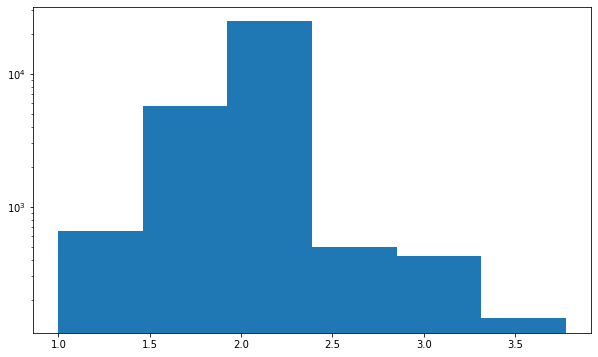

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=6)
plt.yscale('log')
plt.show()

In [ ]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=6,sort=False)


(0.996, 1.463]      662
(1.463, 1.926]     5741
(1.926, 2.388]    24663
(2.388, 2.851]      496
(2.851, 3.314]      427
(3.314, 3.777]      146
Name: Estimate_Score, dtype: int64

Como resultado, se aprecia que las predicciones para este usuario no llegan a valores muy altos, pero los valores altos alcanzan a estar depurados, siendo que valores por encima de 3.3 son solo 146. ¿Cómo se comporta el modelo con un usuario que solo posee un videojuego?

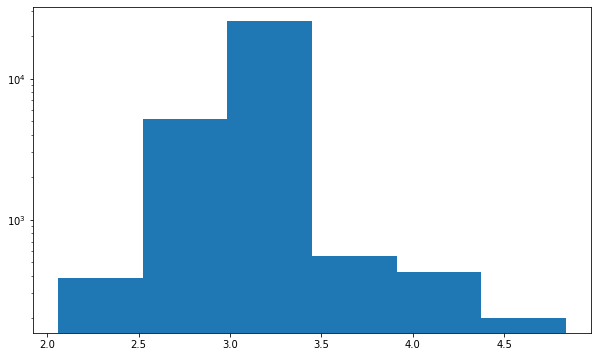

In [ ]:
usuario2 = 'freakfantom'
ranking2 = 10   # Juegos jugados por encima del tiempo promedio
df_user2 = reviws[(reviws['username'] == usuario2) & (reviws['nota'] >= ranking2)]
df_user2 = df_user2.reset_index(drop=True)
usuario_vistas = reviws[reviws['username'] == usuario2]
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: model.predict(usuario2, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)

plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=6)
plt.yscale('log')
plt.show()

In [ ]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=6,sort=False)

(2.0580000000000003, 2.524]      389
(2.524, 2.987]                  5178
(2.987, 3.449]                 25385
(3.449, 3.911]                   555
(3.911, 4.374]                   427
(4.374, 4.836]                   201
Name: Estimate_Score, dtype: int64

Para este caso el modelo genera calificaciones más altas, llegando hasta casi 5. 

In [ ]:
from surprise import accuracy
accuracy.rmse(predictions, verbose=True) 

RMSE: 0.7377


0.7377254175115657

El comportamiento del modelo es sumamente bueno, tiene un error que se encuentra por debajo de la unidad. En terminos generales, este modelo ha tenído un desempeño bastante interesante, por no decir menos. 

#Conclusiones

El modelo, a pesar de tener un comportamiento positivo, necesitaría ser contrastado con datos reales del comportamiento de los usuarios para contrastar su comportamiento con las predicciones realizadas. 

Aunque el modelo ahora es más robusto al contar con datos de uso y poder adquisitivo del usuario, aun puede profundizar más teniendo en cuenta que hay factores que no se han tocado como el factor social, por ejemplo.

El modelo sigue teniendo el problema de que la nota, finalmente, será repartida entre todo el universo de datos de cada usuario, es decir, sus juegos serán ordenados en rangos de horas jugadas e inversión realizada y si bien ello implica que el usuario tendrá recomendaciones acordes a su consumo már reciente, tambien puede indicar que va a dejar de recibir recomendaciones de productos que pueden interesarle. En otras palabras, el modelo asume que el usuario no juega un producto porque le está gustando menos, cuando pueden ser innumerables razones, como por ejemplo que el usuario cambie de equipo y ya no tenga los requerimientos tecnicos para correr los juegos que solia jugar.

Finalmente, este tipo de modelos son un ejercicio sumamente interesante debido a que se estan generando recomendaciones para plataformas que dan muchisima libertad de acción e interacción a sus usuarios: Un usuario  puede o no jugar todos los días el mismo juego, consumir productos gratuitos o pagar un dineral por un extra en un producto... es esa libertad de uso de la plataforma lo que hace interesante buscar acomodar modelos de recomendación a estos datos.

#Implementación 

Este modelo debería implementarse limitando el tiempo de los datos sea anual, semestral o mensual; es decir, olvidar el historial completo del usuario por fuera del periodo estudiado. La razón de ser de esto es que se busca registrar los cambios de comportamiento en el consumo de los usuarios y eso es solo posible si se limita el tiempo, caso contrarío si el usuario, por ejemplo, le ha dedicado 4 horas diarias a un solo juego por 2 años nos va a generar un fuerte sesgo. 

Por otro lado, los habitos de compra si deberían tenerse en cuenta siempre, pues estos no se espera que cambien de un periodo a otro.

#Mejoras

Como se dijo anteriormente, el modelo podría mejorar si se tiene en cuenta el factor social del usuario (ejemplo si tiene amigos dentro de la plataforma de steam, si juega con ellos y que juega con ellos). Otro factor que puede ser de interes es la edad del usuario, pues usuarios mayores pueden tener la tendencia a comprar juegos de su infancia, mientras usuarios menores se acomoden más a las tendencias actuales.